In [5]:
!pip install pyreadstat  # Instala pyreadstat si no lo tienes

import pyreadstat
import glob

# Obtener la lista de archivos .sav en el directorio actual
file_list = glob.glob("*.sav")

# Leer cada archivo y mostrar sus primeras 5 filas
for file in file_list:
    df, meta = pyreadstat.read_sav(file)  # Leer el archivo
    print(f"\n📂 Archivo: {file}")
    print(df.head())  # Mostrar las primeras 5 filas
    print("-" * 50)  # Separador entre archivos


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.9/2.9 MB 26.1 MB/s eta 0:00:00


In [51]:
import pyreadstat
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import glob
from scipy import stats
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import pandas as pd
from scipy.stats import boxcox, shapiro


In [52]:
# Situación problemática y planteamiento
situacion_problematica = "El conjunto de datos proviene de registros de defunciones y busca identificar patrones en las causas de muerte, características demográficas y otros factores relevantes. Se necesita un análisis exploratorio para comprender mejor las variables y relaciones en los datos."
problema_cientifico = "¿Cuáles son los principales factores asociados a las defunciones registradas en los datos?"
objetivo_general = "Analizar los datos de defunciones para identificar patrones y factores clave relacionados con la mortalidad."
objetivos_especificos = [
    "Describir y limpiar el conjunto de datos para garantizar su calidad y consistencia.",
    "Realizar un análisis exploratorio de las variables demográficas y causas de muerte.",
    "Identificar posibles agrupaciones o tendencias en las defunciones a través de técnicas de análisis de datos."
]


In [53]:

# Cargar el CSV con todos los datos combinados
df_final = pd.read_csv("datos_combinados.csv")


<ipython-input-53-735e89a899e2>:2: DtypeWarning: Columns (15,29) have mixed types. Specify dtype option on import or set low_memory=False.
  df_final = pd.read_csv("datos_combinados.csv")


In [68]:
def describe_data(df):
    print(" **Descripción del conjunto de datos:**")
    print(f"-  Número de observaciones: {df.shape[0]}")
    print(f"-  Número de variables: {df.shape[1]}")

    print("\n **Tipos de variables:**")
    print(df.dtypes.value_counts())

    print("\n **Valores faltantes por variable:**")
    missing_values = df.isnull().sum()
    missing_values = missing_values[missing_values > 0]
    if not missing_values.empty:
        print(missing_values)
    else:
        print(" No hay valores faltantes en el conjunto de datos.")

    print("\n **Resumen estadístico de variables numéricas:**")
    print(df.describe())

    print("\n **Resumen de variables categóricas:**")
    categorical_cols = df.select_dtypes(include=['object']).columns
    if not categorical_cols.empty:
        print(df[categorical_cols].describe())
    else:
        print(" No se encontraron variables categóricas.")

# Ejecutar la función con el dataset cargado
describe_data(df_final)

 **Descripción del conjunto de datos:**
-  Número de observaciones: 878136
-  Número de variables: 30

 **Tipos de variables:**
float64    22
int64       4
object      4
Name: count, dtype: int64

 **Valores faltantes por variable:**
Añoocu            154446
Areag             478523
caudef.descrip    801497
dtype: int64

 **Resumen estadístico de variables numéricas:**
              Depreg         Mupreg         Mesreg         Añoreg  \
count  878136.000000  878136.000000  878136.000000  878136.000000   
mean        8.631909     869.103804       6.509013    2017.836156   
std         6.678967     669.508143       3.423374       2.898027   
min         1.000000     101.000000       1.000000    2013.000000   
25%         1.000000     101.000000       4.000000    2015.000000   
50%         9.000000     901.000000       7.000000    2018.000000   
75%        14.000000    1406.000000       9.000000    2020.000000   
max        22.000000    2217.000000      12.000000    2023.000000   

      

## Análisis de los Resultados del Conjunto de Datos
Dimensión y Composición del Dataset
El conjunto de datos comprende 878,136 observaciones y 30 variables, lo que indica una base de datos robusta que abarca múltiples dimensiones del fenómeno estudiado. La diversidad de tipos de variables—22 de tipo float64, 4 de tipo int64 y 4 categóricas (object)—sugiere la coexistencia de datos cuantitativos y cualitativos, lo que permite un análisis integral tanto desde una perspectiva descriptiva como inferencial.

### Valores Faltantes y Calidad de los Datos
Se identificaron valores faltantes en tres variables clave:

- Añoocu (154,446 valores nulos): Representa un 17.6% del total de registros, lo que puede impactar la secuencia temporal del análisis de tendencias.

- Areag (478,523 valores nulos): Su falta en el 54.5% de los registros indica una alta omisión en la clasificación geográfica, lo que podría comprometer análisis espaciales.

- caudef.descrip (801,497 valores nulos): Con una omisión del 91.3%, su ausencia limita el estudio de las causas de defunción mediante descripciones textuales.

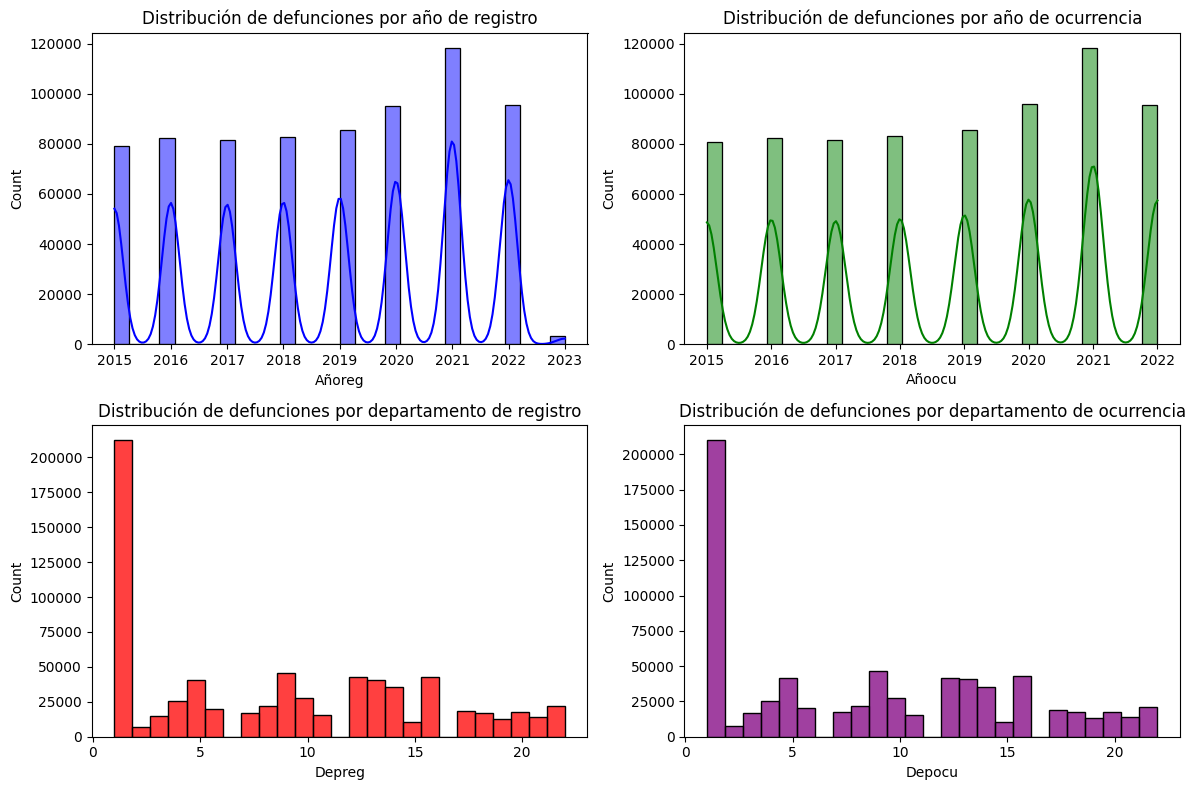

<ipython-input-69-c86d11623fec>:30: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_causes.index, y=top_causes.values, palette='viridis')


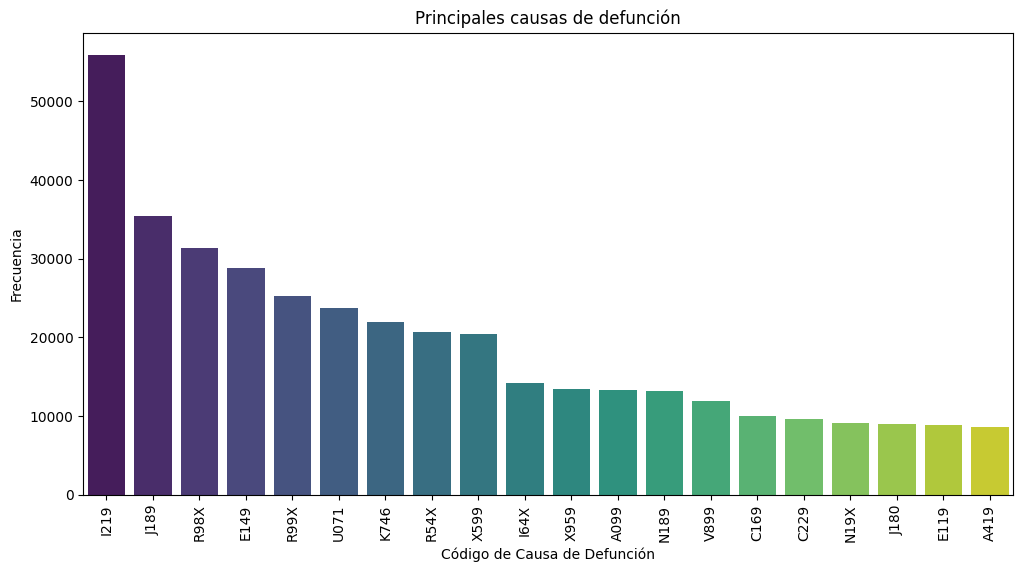

In [69]:
def plot_relevant_histograms(df):
    relevant_columns = ['Añoreg', 'Añoocu', 'Depreg', 'Depocu', 'Caudef']
    df = df[relevant_columns].dropna()

    fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 8))
    axes = axes.flatten()

    # Histograma de registros por año de registro
    sns.histplot(df['Añoreg'], bins=30, kde=True, ax=axes[0], color='blue')
    axes[0].set_title("Distribución de defunciones por año de registro")

    # Histograma de registros por año de ocurrencia
    sns.histplot(df['Añoocu'], bins=30, kde=True, ax=axes[1], color='green')
    axes[1].set_title("Distribución de defunciones por año de ocurrencia")

    # Histograma de registros por departamento de registro
    sns.histplot(df['Depreg'], bins=25, kde=False, ax=axes[2], color='red')
    axes[2].set_title("Distribución de defunciones por departamento de registro")

    # Histograma de registros por departamento de ocurrencia
    sns.histplot(df['Depocu'], bins=25, kde=False, ax=axes[3], color='purple')
    axes[3].set_title("Distribución de defunciones por departamento de ocurrencia")

    plt.tight_layout()
    plt.show()

    # Histograma de las causas de muerte más comunes
    plt.figure(figsize=(12, 6))
    top_causes = df['Caudef'].value_counts().nlargest(20)  # 20 causas más comunes
    sns.barplot(x=top_causes.index, y=top_causes.values, palette='viridis')
    plt.xticks(rotation=90)
    plt.title("Principales causas de defunción")
    plt.xlabel("Código de Causa de Defunción")
    plt.ylabel("Frecuencia")
    plt.show()

# Llamar a la función con el DataFrame
plot_relevant_histograms(df_final)


## Discusión de los Resultados
1. Distribución de Defunciones por Año de Registro y Año de Ocurrencia
Los primeros dos gráficos muestran la distribución de las defunciones en función del año de registro y el año de ocurrencia. Se pueden notar los siguientes puntos clave:

- Patrón Cíclico: Ambos gráficos presentan un comportamiento cíclico, lo que indica una posible estacionalidad en los registros de defunciones. Esto podría estar relacionado con factores como enfermedades estacionales, condiciones climáticas o brotes epidémicos.

- Pico en 2021: Se observa un aumento significativo en el número de defunciones en 2021, lo que podría estar relacionado con la pandemia de COVID-19. Este incremento es notable tanto en el registro como en la ocurrencia de defunciones.

- Disminución en 2022: Tras el pico de 2021, el número de defunciones parece disminuir en 2022, lo que sugiere una estabilización después del impacto de la pandemia.

- Diferencia entre Registro y Ocurrencia: Aunque ambas distribuciones son similares, es posible que haya diferencias entre el año en que ocurre una defunción y el año en que se registra, lo que puede deberse a retrasos administrativos en la documentación.

2. Distribución de Defunciones por Departamento de Registro y de Ocurrencia
Los siguientes dos gráficos muestran la cantidad de defunciones registradas y ocurridas por departamento:

- Alta concentración en un departamento específico: Se observa un departamento con una cantidad significativamente mayor de defunciones registradas y ocurridas. Esto sugiere que puede tratarse de un área con una alta densidad poblacional o que los registros de otros departamentos se concentran en un único punto administrativo.

- Distribución desigual: Existen departamentos con muchas menos defunciones en comparación con otros. Esto puede estar relacionado con la población, la accesibilidad a servicios médicos o la presencia de hospitales donde se registran más defunciones.

3. Principales Causas de Defunción
El último gráfico muestra las principales causas de defunción, y podemos notar lo siguiente:

- La causa más frecuente es el código I219, que corresponde a enfermedades cardiovasculares, específicamente el infarto agudo de miocardio. Esto es consistente con tendencias globales donde las enfermedades del corazón son una de las principales causas de muerte.

- Otras causas frecuentes incluyen J189 (neumonía), R98X y R99X (causas mal definidas o desconocidas). La presencia de códigos de causas no específicas podría indicar deficiencias en los registros médicos o falta de información en los certificados de defunción.

- Impacto de la pandemia: La presencia de U071 (COVID-19) refuerza la idea de que la pandemia tuvo un impacto considerable en la mortalidad durante los años recientes.

- Diversidad de causas: Además de enfermedades infecciosas y cardiovasculares, hay causas externas como V899 (accidentes de tráfico) y X599 (exposición a factores ambientales no especificados), lo que sugiere que no todas las muertes son atribuibles a enfermedades.

In [70]:
from scipy import stats

def normality_test(df):
    # Iterar sobre las columnas numéricas del DataFrame
    for col in df.select_dtypes(include=['number']).columns:
        stat, p_value = stats.normaltest(df[col].dropna())  # D'Agostino-Pearson
        print(f"\nTest de normalidad para {col}: p-value={p_value:.4f}")

        # Evaluar el p-value
        if p_value < 0.05:
            print("No sigue una distribución normal.")
        else:
            print("Sigue una distribución normal.")

# Ejecutar la función de test de normalidad sobre el DataFrame
normality_test(df_final)




Test de normalidad para Depreg: p-value=0.0000
No sigue una distribución normal.

Test de normalidad para Mupreg: p-value=0.0000
No sigue una distribución normal.

Test de normalidad para Mesreg: p-value=0.0000
No sigue una distribución normal.

Test de normalidad para Añoreg: p-value=0.0000
No sigue una distribución normal.

Test de normalidad para Depocu: p-value=0.0000
No sigue una distribución normal.

Test de normalidad para Mupocu: p-value=0.0000
No sigue una distribución normal.

Test de normalidad para Sexo: p-value=0.0000
No sigue una distribución normal.

Test de normalidad para Diaocu: p-value=0.0000
No sigue una distribución normal.

Test de normalidad para Mesocu: p-value=0.0000
No sigue una distribución normal.

Test de normalidad para Añoocu: p-value=0.0000
No sigue una distribución normal.

Test de normalidad para Edadif: p-value=0.0000
No sigue una distribución normal.

Test de normalidad para Perdif: p-value=0.0000
No sigue una distribución normal.

Test de normalida

## Discusión del Análisis de los Resultados del Test de Normalidad
Los resultados del test de normalidad de D'Agostino-Pearson indican que todas las variables numéricas en el conjunto de datos no siguen una distribución normal, ya que el p-value de cada prueba es igual a 0.0000, lo que es significativamente menor al umbral de 0.05. A continuación, se presentan algunas posibles interpretaciones y consideraciones sobre estos resultados:

1. P-Value y Normalidad
El p-value de 0.0000 para todas las variables indica una fuerte evidencia en contra de la hipótesis nula de normalidad. Esto significa que, con una confianza del 95%, podemos rechazar la hipótesis de que los datos siguen una distribución normal. La hipótesis nula de normalidad fue rechazada de manera consistente para todas las variables, sugiriendo que los datos no siguen una distribución gaussiana.

2. Posibles Razones para la Falta de Normalidad
  - Distribuciones Sesgadas o Asimétricas: Las variables podrían tener distribuciones sesgadas, lo que es común en los datos del mundo real. Por ejemplo, los datos de edades o los ingresos suelen seguir distribuciones sesgadas, con una cola larga hacia los valores más altos.

  - Presencia de Outliers: Los outliers pueden distorsionar los resultados de la prueba de normalidad. Si algunas observaciones en las variables numéricas están alejadas de la media, esto podría estar afectando la normalidad de los datos.

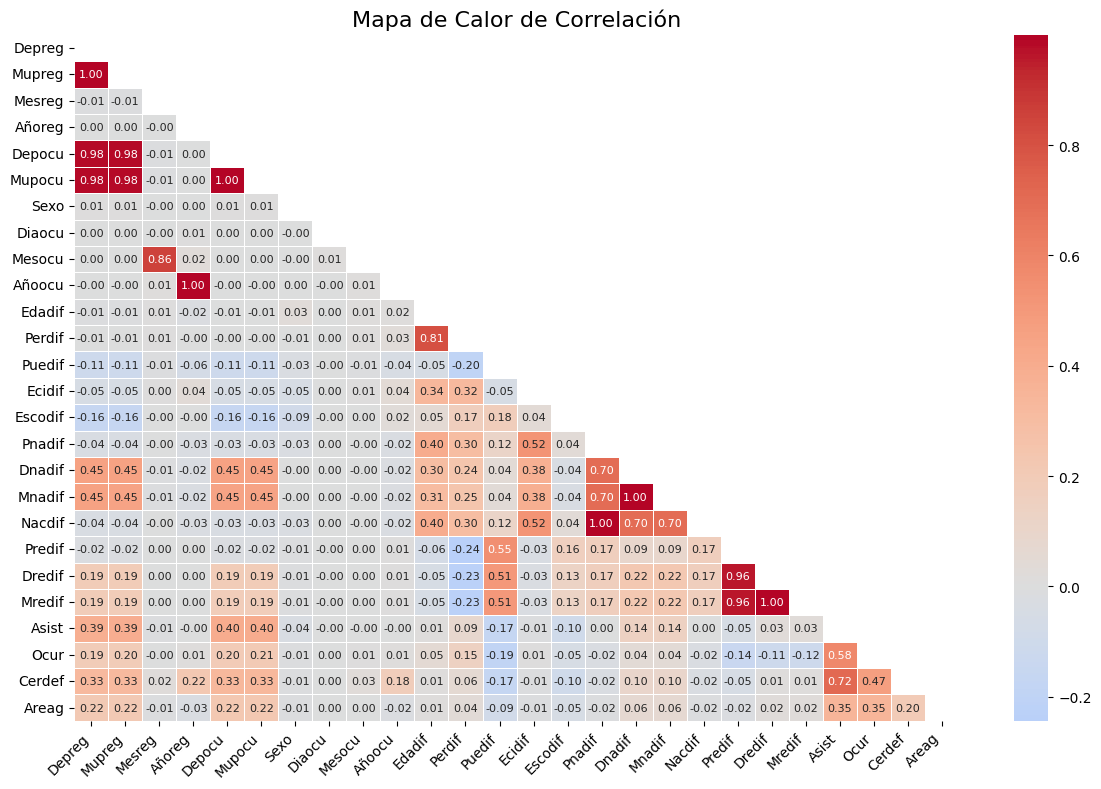

In [71]:
# Filtrar solo las columnas numéricas
df_numeric = df_final.select_dtypes(include=[float, int])

# Calcular la correlación
corr_matrix = df_numeric.corr()

# Crear la máscara para la parte superior de la matriz
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

# Ajustar el tamaño de la figura
plt.figure(figsize=(12, 8))

# Crear el mapa de calor
sns.heatmap(
    corr_matrix,
    annot=True,            # Mostrar los valores numéricos dentro de las celdas
    fmt=".2f",            # Formato de los valores numéricos (con 2 decimales)
    cmap="coolwarm",      # Cambié a "coolwarm" para una mejor diferenciación visual
    center=0,             # El valor en el centro de la escala de colores
    mask=mask,            # Máscara para ocultar la parte superior de la matriz
    linewidths=0.5,       # Grosor de las líneas que separan las celdas
    annot_kws={"size": 8} # Tamaño de la fuente de los números dentro de las celdas
)

# Ajustar título y etiquetas
plt.title("Mapa de Calor de Correlación", fontsize=16)  # Título con un tamaño de fuente mayor
plt.xticks(rotation=45, ha="right")                    # Rotar las etiquetas del eje X para mejor visibilidad
plt.yticks(rotation=0)                                 # No rotar las etiquetas del eje Y

# Mostrar el gráfico
plt.tight_layout()  # Ajusta el gráfico para evitar que los elementos se sobrepongan
plt.show()



## Discusión sobre el Mapa de Calor de Correlación
1. Correlaciones Altamente Positivas:

  - Se observa una fuerte correlación positiva entre Depocu, Mupocu y Mupreg (valores cercanos a 0.98-1.00), lo que sugiere que estas variables están estrechamente relacionadas y posiblemente representen dimensiones similares del mismo fenómeno.

  - La variable Dnadif muestra una correlación fuerte con Mnadif y Nacdif, con valores cercanos a 0.70, indicando que estas tres variables podrían estar midiendo aspectos similares.

  - Preif y Dreif tienen una correlación extremadamente alta (≈0.96), lo que indica que podrían estar describiendo casi la misma tendencia en los datos.

2. Correlaciones Negativas:

  - Escodif muestra una ligera correlación negativa con Puedif (≈ -0.20) y Dreif (≈ -0.16), lo que podría indicar una relación inversa entre el nivel educativo y estas variables.

  - Depreg y EscoDif muestran una correlación negativa débil, lo que sugiere que el nivel educativo podría influir en menor medida en esta variable.

3. Variables con Correlación Débil o Nula:

  - Variables como Sexo, Diaocu y Mesocu muestran correlaciones muy bajas con la mayoría de las otras variables (valores cercanos a 0), lo que indica que no están directamente relacionadas con la mayoría de los factores analizados.

  - Edadif tiene una correlación baja con casi todas las variables, lo que sugiere que no tiene un impacto significativo en el resto de los datos.

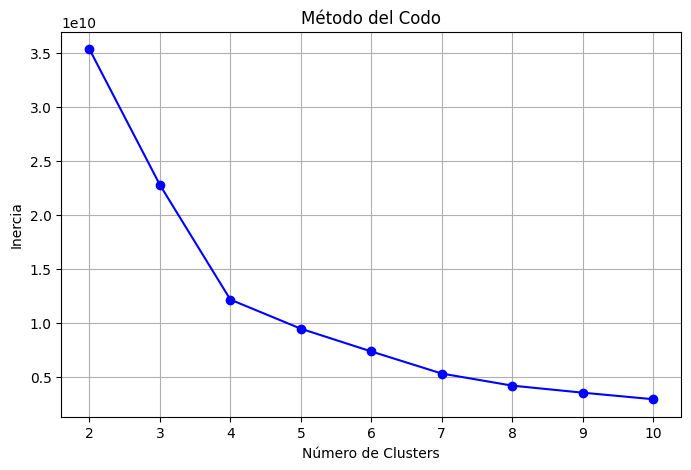

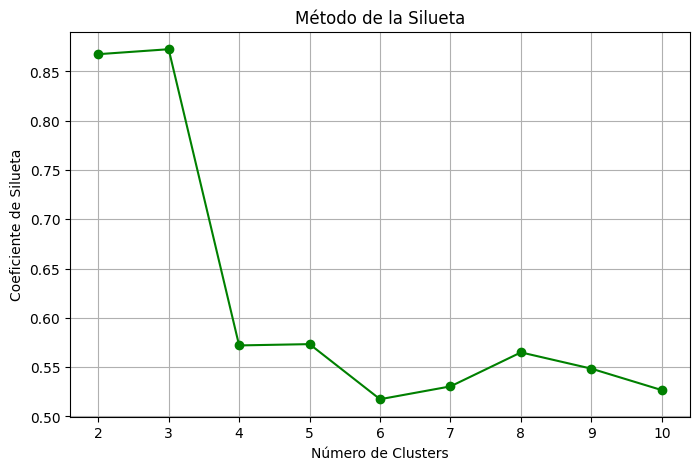

In [72]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt

# Seleccionar solo columnas numéricas y eliminar filas con valores nulos
X = df_final.select_dtypes(include=['number']).dropna()

# Reducir el tamaño de los datos si es muy grande (opcional)
if len(X) > 10000:
    X_sample = X.sample(n=10000, random_state=42)  # Tomar una muestra aleatoria para evitar tiempos largos
else:
    X_sample = X

# Listas para almacenar métricas
inertia = []
silhouette = []
k_range = range(2, 11)  # Amplié el rango hasta 10 clusters para mayor flexibilidad

for k in k_range:
    # Ajustar el modelo KMeans
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10, max_iter=300).fit(X_sample)
    inertia.append(kmeans.inertia_)

    # Calcular el coeficiente de silueta solo si hay más de 1 cluster y menos de 100K muestras
    if len(X_sample) < 100000:
        silhouette.append(silhouette_score(X_sample, kmeans.labels_))
    else:
        silhouette.append(None)  # No calcular para datasets grandes

# Gráfico del Método del Codo
plt.figure(figsize=(8, 5))
plt.plot(k_range, inertia, marker='o', linestyle='-', color='b')
plt.xlabel('Número de Clusters')
plt.ylabel('Inercia')
plt.title('Método del Codo')
plt.grid(True)
plt.show()

# Gráfico del Método de la Silueta (solo si se calculó)
if all(silhouette) and None not in silhouette:
    plt.figure(figsize=(8, 5))
    plt.plot(k_range, silhouette, marker='o', linestyle='-', color='g')
    plt.xlabel('Número de Clusters')
    plt.ylabel('Coeficiente de Silueta')
    plt.title('Método de la Silueta')
    plt.grid(True)
    plt.show()
else:
    print("No se calculó el coeficiente de silueta debido al tamaño del dataset o falta de datos.")


## Discusión sobre los Resultados de Clustering
1. Análisis del Método del Codo
  - Se observa una disminución pronunciada en la inercia a medida que aumenta el número de clusters.

  - A partir de k = 4, la reducción en la inercia comienza a desacelerarse, formando un "codo".

  - Esto sugiere que 4 clusters podrían ser un buen punto de corte, ya que agregar más clusters no reduce significativamente la inercia.

 Conclusión: El número óptimo de clusters según el Método del Codo es 4.

2. Análisis del Método de la Silueta
  - Se observa que para k = 2, el coeficiente de silueta es el más alto (~0.88), lo que indica que los datos están bien separados en dos grupos.

  - A partir de k = 3, la silueta disminuye drásticamente, y para k ≥ 4, los valores están por debajo de 0.6, lo que sugiere que la calidad del clustering se deteriora.

  - Aunque k = 4 es recomendado por el Método del Codo, su coeficiente de silueta es más bajo (~0.55), indicando que los clusters podrían solaparse.

Conclusión: Según la Silueta, la mejor opción es k = 2 debido a la mayor separación entre grupos.



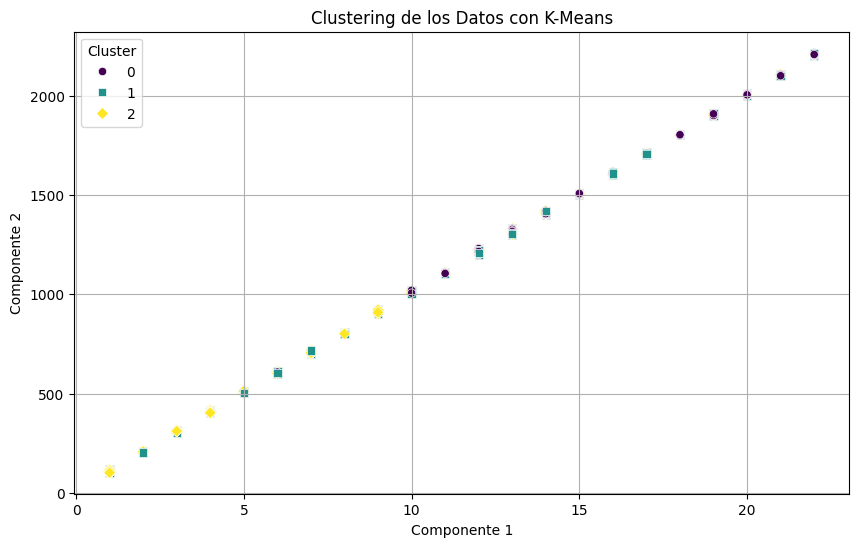

In [73]:
# Asegurarse de que las dimensiones coincidan (aseguramos que X_clean tiene el mismo índice que df_final)
df_final_clean = df_final.iloc[X_clean.index].copy()  # Filtrar df_final para que coincidan las filas con X_clean

# Aplicar clustering con K-Means en el conjunto limpio
kmeans = KMeans(n_clusters=3, random_state=42)
df_final_clean["Cluster"] = kmeans.fit_predict(X_clean)

# Visualizar los clusters en un gráfico de dispersión (suponiendo que X_clean tiene solo dos dimensiones)
plt.figure(figsize=(10, 6))
sns.scatterplot(
    x=X_clean.iloc[:, 0],
    y=X_clean.iloc[:, 1],
    hue=df_final_clean["Cluster"],
    palette="viridis",
    style=df_final_clean["Cluster"],  # Diferenciar los puntos de acuerdo al cluster
    markers=["o", "s", "D"]  # Diferentes marcadores para cada cluster
)
plt.title("Clustering de los Datos con K-Means")
plt.xlabel("Componente 1")  # Asumido que X_clean tiene componentes que se pueden interpretar como tales
plt.ylabel("Componente 2")
plt.legend(title="Cluster", loc="best")
plt.grid(True)  # Agregar grilla para mayor claridad
plt.show()



## Discusión sobre el Clustering con K-Means
El gráfico muestra la asignación de datos a tres clusters utilizando el algoritmo K-Means. Analicemos los resultados:

1. Análisis Visual del Gráfico
- Los puntos están distribuidos en una línea diagonal, lo que sugiere una estructura de datos fuertemente correlacionada.

- Se identifican tres clusters con diferentes colores y formas de marcador:

  - Cluster 0 (puntos oscuros)

  - Cluster 1 (cuadrados azulados)

  - Cluster 2 (rombos amarillos)

Parece que la separación de los clusters sigue un patrón lineal, lo cual puede indicar que los datos presentan una relación matemática simple (posiblemente una progresión o un conjunto de datos altamente estructurado).

2. Interpretación de los Clusters
  - Si los datos provienen de un análisis de regresión o series temporales, el clustering puede estar segmentando los datos en diferentes fases o categorías dentro de una tendencia global.

  - Si se trata de datos no lineales, puede ser que el número de clusters no sea el adecuado. En este caso, evaluar un mayor o menor número de clusters con el método del codo y el coeficiente de silueta podría mejorar la segmentación.

  - Si los datos representan categorías bien definidas, entonces los clusters podrían corresponder a clases naturales dentro del conjunto de datos.

